In [1]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import linalg as LA
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
def covariance(X):
    return np.dot(X,X.T)/np.trace(np.dot(X,X.T))

def get_feat(data,sf):
    return np.log(np.var(np.dot(sf.T,data.T),axis=1)) #check axis

In [3]:
def get_spatial(left, right, J):
    c = left + right
    eigvals,eigvecs = LA.eig(c)
    diag_inv = np.zeros((c.shape[1],c.shape[1]))
    for i in range(eigvals.shape[0]):
        diag_inv[i,i]=(1/np.abs(eigvals[i].real))
        
    P = np.sqrt(diag_inv)*eigvecs.T
    s_l = P* left*P.T
    s_r = P* right*P.T
    E1, U1 = LA.eig(s_l,s_r)
    ord1 = np.argsort(E1)
    ord1 = ord1[::-1]
    E1 = E1[ord1]
    U1 = U1[:,ord1]
    W = np.dot(U1,P)
    W_select = np.zeros([np.shape(W)[0],2*J])
    W_select[:,0:J]=W[:,0:J]
    W_select[:,J::] = W[:,np.shape(W)[1]-J:np.shape(W)[1]]
    return W_select

In [4]:
num_sub=14
features_test=dict()
features_train=dict()
labels_train=dict()
labels_test=dict()
num_channels=15
hand=np.zeros((num_channels,num_channels))
leg=np.zeros((num_channels,num_channels))
labels=[]
spatial_filter=dict()
for sub in range(num_sub):
    features_train[sub]=[]
    labels_train[sub]=[]
    file_train = 'S0%dT.mat'% (sub+1)
#     mat_train = scipy.io.loadmat(file_train)
    if (sub+1)<10:    
        file_train='S0%dT.mat'% (sub+1)
        mat_train=scipy.io.loadmat(file_train)
    else:
        file_train='S%dT.mat'% (sub+1)
        mat_train=scipy.io.loadmat(file_train)
    data_train=mat_train['data']
    for k in range(5):
        cell_train=data_train[0][k]
        X_train=cell_train[0][0][0]
        time_train=cell_train[0][0][1]
        labels_x_train=cell_train[0][0][2]
        labels_train[sub].extend(labels_x_train[0])
        var=0
        for l_x in range(len(labels_x_train[0])):
            if labels_x_train[0][l_x]==1:
                hand+=covariance(X_train[var:time_train[0][l_x],:].T) #transpose because we need num_channel vs num_channel
            else:
                leg+=covariance(X_train[var:time_train[0][l_x],:].T)
            var=time_train[0][l_x]
        mean_hand=hand/num_sub
        mean_leg=leg/num_sub
        num_features=3 
        spatial_filter[sub]=get_spatial(mean_hand,mean_leg,num_features)
    
        var=0
        for count in range(len(time_train[0])):
            features_train[sub].append(get_feat(X_train[var:time_train[0][count],:],spatial_filter[sub]))
            var=time_train[0][count]    
    features_train[sub]=np.array(features_train[sub]) 
    np.random.shuffle(features_train[sub])
print("Training Features Computed\n Computing Testing features...")
for sub in range(num_sub): 
    features_test[sub]=[]
    labels_test[sub]=[]
    file_test = 'S0%dE.mat'% (sub+1)
#     mat_test = scipy.io.loadmat(file_train)
    if (sub+1)<10:
        file_test='S0%dE.mat'% (sub+1)
        mat_test=scipy.io.loadmat(file_test)
    else:
        file_test='S%dE.mat'% (sub+1)
        mat_test=scipy.io.loadmat(file_test)
    data_test=mat_test['data']
    for k in range(3):    
        cell_test=data_test[0][k]
        X_test=cell_test[0][0][0]
        time_test=cell_test[0][0][1]
        labels_x_test=cell_test[0][0][2]
        labels_test[sub].extend(labels_x_test[0])    
        var=0
        for count in range(len(time_test[0])):
            features_test[sub].append(get_feat(X_test[var:time_test[0][count],:],spatial_filter[sub]))
            var=time_test[0][count]   
    features_test[sub]=np.array(features_test[sub])
    np.random.shuffle(features_test[sub])
print("Features for training and Testing computed")

Training Features Computed
 Computing Testing features...
Features for training and Testing computed


In [5]:
labels_tr = np.array(labels_train[sub])
labels_ts = np.array(labels_test[sub])
features_tr = features_train[sub]
features_ts = features_test[sub]


In [18]:
model = keras.Sequential([keras.layers.Dense(16,input_dim=np.shape(features_tr)[1], activation='sigmoid', kernel_initializer='uniform'),
                          keras.layers.Dense(30, activation = 'sigmoid', kernel_initializer = 'uniform'),
                          keras.layers.Dense(1,activation='sigmoid', kernel_initializer='uniform')])

In [19]:
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['acc'])

In [20]:
history=model.fit(features_tr,labels_tr, epochs=20, validation_split = 0.2)

Train on 80 samples, validate on 20 samples
Epoch 1/20
80/80 [==============================] - 1s 7ms/sample - loss: 0.6146 - acc: 0.5000 - val_loss: 0.5767 - val_acc: 0.5000
Epoch 2/20
80/80 [==============================] - 0s 175us/sample - loss: 0.5636 - acc: 0.5000 - val_loss: 0.5252 - val_acc: 0.5000
Epoch 3/20
80/80 [==============================] - 0s 175us/sample - loss: 0.5118 - acc: 0.5000 - val_loss: 0.4741 - val_acc: 0.5000
Epoch 4/20
80/80 [==============================] - 0s 167us/sample - loss: 0.4596 - acc: 0.5000 - val_loss: 0.4231 - val_acc: 0.5000
Epoch 5/20
80/80 [==============================] - 0s 163us/sample - loss: 0.4097 - acc: 0.5000 - val_loss: 0.3719 - val_acc: 0.5000
Epoch 6/20
80/80 [==============================] - 0s 175us/sample - loss: 0.3588 - acc: 0.5000 - val_loss: 0.3208 - val_acc: 0.5000
Epoch 7/20
80/80 [==============================] - 0s 162us/sample - loss: 0.3073 - acc: 0.5000 - val_loss: 0.2697 - val_acc: 0.5000
Epoch 8/20
80/80 [==

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16)                112       
_________________________________________________________________
dense_11 (Dense)             (None, 30)                510       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 31        
Total params: 653
Trainable params: 653
Non-trainable params: 0
_________________________________________________________________


In [22]:
training_pred = model.predict(features_tr)
testing_pred = model.predict(features_ts)
performance = model.evaluate(features_ts, labels_ts)
print(performance)

60/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [23]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

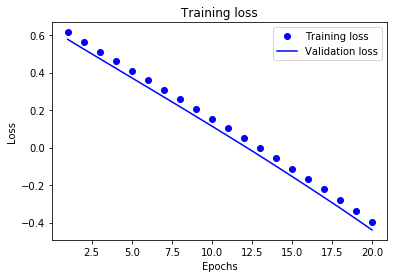

In [24]:
# Checking Overfit
acc = history_dict['acc']
loss = history_dict['loss']
val_acc = history_dict['val_acc']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [25]:
model1 = keras.Sequential([keras.layers.Dense(16,input_dim=np.shape(features_ts)[1], activation='sigmoid', kernel_initializer='uniform'),
                          keras.layers.Dense(30, activation = 'sigmoid', kernel_initializer = 'uniform'),
                          keras.layers.Dense(1,activation='sigmoid', kernel_initializer='uniform')])

In [26]:
model1.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['acc'])

In [27]:
history1=model1.fit(features_ts,labels_ts, epochs=30, validation_split = 0.2)

Train on 48 samples, validate on 12 samples
Epoch 1/30
48/48 [==============================] - 0s 9ms/sample - loss: 0.7650 - acc: 0.0000e+00 - val_loss: 0.7297 - val_acc: 0.0000e+00
Epoch 2/30
48/48 [==============================] - 0s 292us/sample - loss: 0.7269 - acc: 0.0000e+00 - val_loss: 0.6974 - val_acc: 0.0000e+00
Epoch 3/30
48/48 [==============================] - 0s 250us/sample - loss: 0.6917 - acc: 0.1458 - val_loss: 0.6653 - val_acc: 0.5833
Epoch 4/30
48/48 [==============================] - 0s 271us/sample - loss: 0.6556 - acc: 0.4792 - val_loss: 0.6336 - val_acc: 0.5833
Epoch 5/30
48/48 [==============================] - 0s 271us/sample - loss: 0.6203 - acc: 0.4792 - val_loss: 0.6021 - val_acc: 0.5833
Epoch 6/30
48/48 [==============================] - 0s 271us/sample - loss: 0.5866 - acc: 0.4792 - val_loss: 0.5709 - val_acc: 0.5833
Epoch 7/30
48/48 [==============================] - 0s 271us/sample - loss: 0.5504 - acc: 0.4792 - val_loss: 0.5400 - val_acc: 0.5833
Epoc

In [28]:
history_dict = history1.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

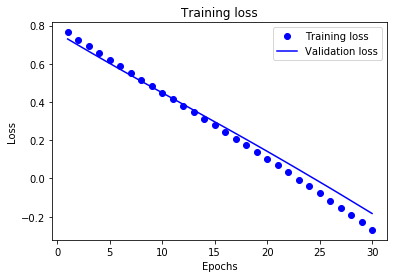

In [29]:
# Checking Overfit
acc = history_dict['acc']
loss = history_dict['loss']
val_acc = history_dict['val_acc']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()